# Workflow for a multi-regional energy system

In this application of the FINE framework, a multi-regional energy system is modeled and optimized.

All classes which are available to the user are utilized and examples of the selection of different parameters within these classes are given.

The workflow is structures as follows:
1. Required packages are imported and the input data path is set
2. An energy system model instance is created
3. Commodity sources are added to the energy system model
4. Commodity conversion components are added to the energy system model
5. Commodity storages are added to the energy system model
6. Commodity transmission components are added to the energy system model
7. Commodity sinks are added to the energy system model
8. The energy system model is optimized
9. Selected optimization results are presented


# 1. Import required packages and set input data path

The FINE framework is imported which provides the required classes and functions for modeling the energy system.

In [1]:
import FINE as fn
from getData import getData
import os
cwd = os.getcwd()
data = getData()

%matplotlib inline  
%load_ext autoreload
%autoreload 2

# 2. Create an energy system model instance 

The structure of the energy system model is given by the considered locations, commodities, the number of time steps as well as the hours per time step.

The commodities are specified by a unit (i.e. 'GW_electric', 'GW_H2lowerHeatingValue', 'Mio. t CO2/h') which can be given as an energy or mass unit per hour. Furthermore, the cost unit and length unit are specified.

In [2]:
locations = {'cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7'}
commodityUnitDict = {'electricity': r'GW$_{el}$', 'methane': r'GW$_{CH_{4},LHV}$', 'biogas': r'GW$_{biogas,LHV}$',
                     'CO2': r'Mio. t$_{CO_2}$/h', 'hydrogen': r'GW$_{H_{2},LHV}$'}
commodities = {'electricity', 'hydrogen', 'methane', 'biogas', 'CO2'}
numberOfTimeSteps=8760
hoursPerTimeStep=1

In [3]:
esM = fn.EnergySystemModel(locations=locations, commodities=commodities, numberOfTimeSteps=8760,
                           commodityUnitsDict=commodityUnitDict,
                           hoursPerTimeStep=1, costUnit='1e9 Euro', lengthUnit='km', verboseLogLevel=0)

In [4]:
CO2_reductionTarget = 1

# 3. Add commodity sources to the energy system model

## 3.1. Electricity sources

### Wind onshore

In [5]:
esM.add(fn.Source(esM=esM, name='Wind (onshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (onshore), operationRateMax'],
                  capacityMax=data['Wind (onshore), capacityMax'],
                  investPerCapacity=1.1, opexPerCapacity=1.1*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [6]:
data['Wind (onshore), operationRateMax'].sum()

cluster_0    2300.406907
cluster_1    1082.032187
cluster_2    1447.812026
cluster_3    1448.827987
cluster_4    1935.618218
cluster_5    1757.696047
cluster_6    1286.944636
cluster_7    1199.380071
dtype: float64

### Wind offshore

In [7]:
esM.add(fn.Source(esM=esM, name='Wind (offshore)', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['Wind (offshore), operationRateMax'],
                  capacityMax=data['Wind (offshore), capacityMax'],
                  investPerCapacity=2.3, opexPerCapacity=2.3*0.02, interestRate=0.08,
                  economicLifetime=20))

Full load hours:

In [8]:
data['Wind (offshore), operationRateMax'].sum()

cluster_0    4332.977326
cluster_1       0.000000
cluster_2       0.000000
cluster_3       0.000000
cluster_4    3963.044612
cluster_5    3459.283279
cluster_6       0.000000
cluster_7       0.000000
dtype: float64

### PV

In [9]:
esM.add(fn.Source(esM=esM, name='PV', commodity='electricity', hasCapacityVariable=True,
                  operationRateMax=data['PV, operationRateMax'], capacityMax=data['PV, capacityMax'],
                  investPerCapacity=0.65, opexPerCapacity=0.65*0.02, interestRate=0.08,
                  economicLifetime=25))

Full load hours:

In [10]:
data['PV, operationRateMax'].sum()

cluster_0    859.175855
cluster_1    970.535848
cluster_2    913.049274
cluster_3    917.880212
cluster_4    875.448945
cluster_5    904.590003
cluster_6    984.223517
cluster_7    992.311727
dtype: float64

### Exisisting run-of-river hydroelectricity plants

In [11]:
esM.add(fn.Source(esM=esM, name='Existing run-of-river plants', commodity='electricity',
                  hasCapacityVariable=True,
                  operationRateFix=data['Existing run-of-river plants, operationRateFix'], tsaWeight=0.01,
                  capacityFix=data['Existing run-of-river plants, capacityFix'],
                  investPerCapacity=0, opexPerCapacity=0.208))

## 3.2. Methane (natural gas and biogas)

### Natural gas

In [12]:
esM.add(fn.Source(esM=esM, name='Natural gas purchase', commodity='methane',
                  hasCapacityVariable=False, commodityCost=0.0331*1e-3))

### Biogas

In [13]:
esM.add(fn.Source(esM=esM, name='Biogas purchase', commodity='biogas',
                  operationRateMax=data['Biogas, operationRateMax'], hasCapacityVariable=False,
                  commodityCost=0.05409*1e-3))

## 3.3 CO2

### CO2

The CO2 source is required for the case in which it can be mixed with conventional natural gas.

In [14]:
esM.add(fn.Source(esM=esM, name='CO2 from enviroment', commodity='CO2',
                  hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 4. Add conversion components to the energy system model

### Combined cycle gas turbine plants

In [15]:
esM.add(fn.Conversion(esM=esM, name='CCGT plants (methane)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'methane':-1/0.625, 'CO2':201*1e-6/0.625},
                      hasCapacityVariable=True,
                      investPerCapacity=0.65, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycle gas turbine plants for biogas

In [16]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (biogas)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'biogas':-1/0.635},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### New combined cycly gas turbines for hydrogen

In [17]:
esM.add(fn.Conversion(esM=esM, name='New CCGT plants (hydrogen)', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.7, opexPerCapacity=0.021, interestRate=0.08,
                      economicLifetime=33))

### Electrolyzers

In [18]:
esM.add(fn.Conversion(esM=esM, name='Electroylzers', physicalUnit=r'GW$_{el}$',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.7},
                      hasCapacityVariable=True, 
                      investPerCapacity=0.5, opexPerCapacity=0.5*0.025, interestRate=0.08,
                      economicLifetime=10))

### rSOC

In [19]:
capexRSOC=1.5

esM.add(fn.Conversion(esM=esM, name='rSOEC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':-1, 'hydrogen':0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

esM.add(fn.Conversion(esM=esM, name='rSOFC', physicalUnit=r'GW$_{el}$', linkedConversionCapacityID='rSOC',
                      commodityConversionFactors={'electricity':1, 'hydrogen':-1/0.6},
                      hasCapacityVariable=True, 
                      investPerCapacity=capexRSOC/2, opexPerCapacity=capexRSOC*0.02/2, interestRate=0.08,
                      economicLifetime=10))

# 5. Add commodity storages to the energy system model

## 5.1. Electricity storage

### Lithium ion batteries

The self discharge of a lithium ion battery is here described as 3% per month. The self discharge per hours is obtained using the equation (1-$\text{selfDischarge}_\text{hour})^{30*24\text{h}} = 1-\text{selfDischarge}_\text{month}$.

In [20]:
esM.add(fn.Storage(esM=esM, name='Li-ion batteries', commodity='electricity',
                   hasCapacityVariable=True, chargeEfficiency=0.95,
                   cyclicLifetime=10000, dischargeEfficiency=0.95, selfDischarge=1-(1-0.03)**(1/(30*24)),
                   chargeRate=1, dischargeRate=1, doPreciseTsaModeling=False,
                   investPerCapacity=0.151, opexPerCapacity=0.002, interestRate=0.08,
                   economicLifetime=22))

## 5.2. Hydrogen storage

### Hydrogen filled salt caverns
The maximum capacity is here obtained by: dividing the given capacity (which is given for methane) by the lower heating value of methane and then multiplying it with the lower heating value of hydrogen.

In [21]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (hydrogen)', commodity='hydrogen',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=133,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (hydrogen), capacityMax'],
                   investPerCapacity=0.00011, opexPerCapacity=0.00057, interestRate=0.08,
                   economicLifetime=30))

## 5.3. Methane storage

### Methane filled salt caverns

In [22]:
esM.add(fn.Storage(esM=esM, name='Salt caverns (biogas)', commodity='biogas',
                   hasCapacityVariable=True, capacityVariableDomain='continuous',
                   capacityPerPlantUnit=443,
                   chargeRate=1/470.37, dischargeRate=1/470.37, sharedPotentialID='Existing salt caverns',
                   stateOfChargeMin=0.33, stateOfChargeMax=1, capacityMax=data['Salt caverns (methane), capacityMax'],
                   investPerCapacity=0.00004, opexPerCapacity=0.00001, interestRate=0.08,
                   economicLifetime=30))

## 5.4 Pumped hydro storage

### Pumped hydro storage

In [23]:
esM.add(fn.Storage(esM=esM, name='Pumped hydro storage', commodity='electricity',
                   chargeEfficiency=0.88, dischargeEfficiency=0.88,
                   hasCapacityVariable=True, selfDischarge=1-(1-0.00375)**(1/(30*24)),
                   chargeRate=0.16, dischargeRate=0.12, capacityFix=data['Pumped hydro storage, capacityFix'],
                   investPerCapacity=0, opexPerCapacity=0.000153))

# 6. Add commodity transmission components to the energy system model

## 6.1. Electricity transmission

### AC cables

esM.add(fn.LinearOptimalPowerFlow(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix'],
                                  reactances=data['AC cables, reactances']))

In [24]:
esM.add(fn.Transmission(esM=esM, name='AC cables', commodity='electricity',
                                  hasCapacityVariable=True, capacityFix=data['AC cables, capacityFix']))

The distances of a component are set to a normalized value of 1.


### DC cables

In [25]:
esM.add(fn.Transmission(esM=esM, name='DC cables', commodity='electricity', losses=data['DC cables, losses'],
                        distances=data['DC cables, distances'],
                        hasCapacityVariable=True, capacityFix=data['DC cables, capacityFix']))

## 6.2 Methane transmission

### Methane pipeline

In [26]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (biogas)', commodity='biogas', 
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000037, investIfBuilt=0.000314,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipelines (methane)')._mapC['cluster_0_cluster_4'][1]

## 6.3 Hydrogen transmission

### Hydrogen pipelines

In [27]:
esM.add(fn.Transmission(esM=esM, name='Pipelines (hydrogen)', commodity='hydrogen',
                        distances=data['Pipelines, distances'],
                        hasCapacityVariable=True, hasIsBuiltBinaryVariable=True, bigM=300,
                        locationalEligibility=data['Pipelines, eligibility'],
                        capacityMax=data['Pipelines, eligibility']*15, sharedPotentialID='pipelines',
                        investPerCapacity=0.000177, investIfBuilt=0.00033,
                        interestRate=0.08, economicLifetime=40))

esM.getComponent('Pipeline (hydrogen)')._mapC

# 7. Add commodity sinks to the energy system model

## 7.1. Electricity sinks

### Electricity demand

In [28]:
esM.add(fn.Sink(esM=esM, name='Electricity demand', commodity='electricity',
                hasCapacityVariable=False, operationRateFix=data['Electricity demand, operationRateFix']))

## 7.2. Hydrogen sinks

### Fuel cell electric vehicle (FCEV) demand

In [29]:
FCEV_penetration=0.5
esM.add(fn.Sink(esM=esM, name='Hydrogen demand', commodity='hydrogen', hasCapacityVariable=False,
                operationRateFix=data['Hydrogen demand, operationRateFix']*FCEV_penetration))

## 7.3. CO2 sinks

### CO2 exiting the system's boundary

In [30]:
esM.add(fn.Sink(esM=esM, name='CO2 to enviroment', commodity='CO2',
                hasCapacityVariable=False, commodityLimitID='CO2 limit', yearlyLimit=366*(1-CO2_reductionTarget)))

# 8.1 Spatial Aggregation

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
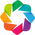

/home/r-beer/code/FINE/FINE/utils.py:799: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  val.parent = self


elapsed time for distance_based_clustering: 0.00 minutes


/home/r-beer/.conda/envs/spagat_py36/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/r-beer/code/FINE/FINE/utils.py:799: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  val.parent = self


In [31]:
from FINE.IOManagement import xarray_io as xrio

shapefile_folder = os.path.join('/home/r-beer/code/FINE/examples/Multi-regional_Energy_System_Workflow/', 
                                'InputData/SpatialData/ShapeFiles/')

locFilePath = os.path.join(shapefile_folder, 'clusteredRegions.shp')

esM_aggregated = xrio.spatial_aggregation(esM, n_regions=3, 
                                              locFilePath=locFilePath,
                                              aggregatedShapefileFolderPath=shapefile_folder)

aggregated_regions_FilePath = os.path.join(shapefile_folder, 'aggregated_regions.shp')
aggregated_grid_FilePath = os.path.join(shapefile_folder, 'aggregated_grid.shp')

All components are now added to the model and the model can be optimized. If the computational complexity of the optimization should be reduced, the time series data of the specified components can be clustered before the optimization and the parameter timeSeriesAggregation is set to True in the optimize call.

# 8.2 Temporal Aggregation

In [32]:
esM.cluster(numberOfTypicalPeriods=7)
esM_aggregated.cluster(numberOfTypicalPeriods=7)


Clustering time series data with 7 typical periods and 24 time steps per period...


/home/r-beer/.conda/envs/spagat_py36/lib/python3.6/site-packages/tsam/timeseriesaggregation.py:960: UserWarning: Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series
  "Something went wrong: At least one maximal value of the aggregated time series exceeds the maximal value the input time series")


		(2.6477 sec)


Clustering time series data with 7 typical periods and 24 time steps per period...
		(0.8751 sec)



### Optimization

In [33]:
esM.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.4844 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.3613 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(1.6736 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.4485 sec)

Declaring shared potential constraint...
		(0.0016 sec)

Declaring commodity balances...
		(0.6310 sec)

Declaring objective function...
		(0.2621 sec)

Read LP format model from file /home/r-beer/code/FINE/examples/Multi-regional_Energy_System_Workflow/tmppcqkmjwa.pyomo.lp
Reading time = 0.18 

for SourceSinkModel ...    (0.8745sec)
for ConversionModel ...    (0.6407sec)
for StorageModel ...       (1.9804sec)
for TransmissionModel ...  (1.8014sec)
		(5.2973 sec)



In [34]:
esM_aggregated.optimize(timeSeriesAggregation=True, optimizationSpecs='OptimalityTol=1e-3 method=2 cuts=0')

Time series aggregation specifications:
Number of typical periods:7, number of time steps per periods:24

Declaring sets, variables and constraints for SourceSinkModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.2014 sec)

Declaring sets, variables and constraints for ConversionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0679 sec)

Declaring sets, variables and constraints for StorageModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.6585 sec)

Declaring sets, variables and constraints for TransmissionModel
	declaring sets... 
	declaring variables... 
	declaring constraints... 
		(0.0708 sec)

Declaring shared potential constraint...
		(0.0008 sec)

Declaring commodity balances...
		(0.7420 sec)

Declaring objective function...
		(0.0984 sec)

Read LP format model from file /home/r-beer/code/FINE/examples/Multi-regional_Energy_System_Workflow/tmpwifg3a_g.pyomo.lp
Reading time = 0.11 

# 9. Selected results output

Plot locations (GeoPandas required)

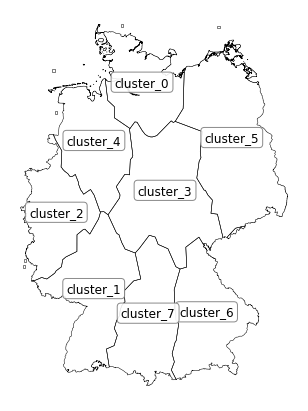

In [35]:
locFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'clusteredRegions.shp')
fig, ax = fn.plotLocations(locFilePath, plotLocNames=True, indexColumn='index')

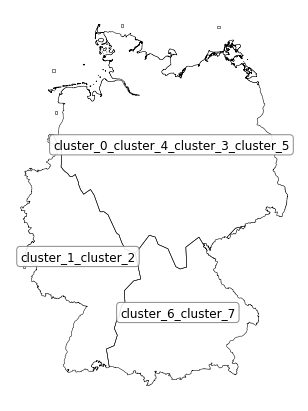

In [36]:
fig, ax = fn.plotLocations(aggregated_regions_FilePath, plotLocNames=True, indexColumn='index')

### Sources and Sink

Show optimization summary

In [37]:
esM.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.450598   
                             commodCosts [1e9 Euro/a]             0.450598   
                             operation   [GW$_{biogas,LHV}$*h/a]   8330.51   
Electricity demand           operation   [GW$_{el}$*h/a]           30957.9   
Existing run-of-river plants TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    4765.07   
PV                           TAC         [1e9 Euro/a]              1.32784   
                             capacity    [GW$_{el}$]               17.9701   
                             capexCap    [1e9 Euro/a]              1.09422   
                             invest      [1e9 Euro]                11.6806   
                             operation   [GW$_{el}$*h/a]           11106.9   
                             opexCap     [1e9 Euro/a]             0.233612   
Wind (offshore)              TAC         [1e9 Euro/a]              4.51415   
                             capacity    [GW$_{el}$]                16.107   
                             capexCap    [1e9 Euro/a]              3.77323   
                             invest      [1e9 Euro]                37.0461   
                             operation   [GW$_{el}$*h/a]             52073   
                             opexCap     [1e9 Euro/a]             0.740923   
Wind (onshore)               TAC         [1e9 Euro/a]              7.79686   
                             capacity    [GW$_{el}$]               58.1693   
                             capexCap    [1e9 Euro/a]              6.51714   
                             invest      [1e9 Euro]                63.9862   
                             operation   [GW$_{el}$*h/a]            107522   
                             opexCap     [1e9 Euro/a]              1.27972   

                                                                 cluster_1  \
Component                    Property    Unit                                
Biogas purchase              TAC         [1e9 Euro/a]             0.407035   
                             commodCosts [1e9 Euro/a]             0.407035   
                             operation   [GW$_{biogas,LHV}$*h/a]   7525.14   
Electricity demand           operation   [GW$_{el}$*h/a]            111621   
Existing run-of-river plants TAC         [1e9 Euro/a]             0.113235   
                             capacity    [GW$_{el}$]              0.544397   
                             operation   [GW$_{el}$*h/a]           2668.85   
                             opexCap     [1e9 Euro/a]             0.113235   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]    13481.3   
PV                           TAC         [1e9 Euro/a]              1.90692   
                             capacity    [GW$_{el}$]               25.8072   
                             capexCap    [1e9 Euro/a]              1.57143   
                             invest      [1e9 Euro]                16.7747   
                             operation   [GW$_{el}$*h/a]           24050.7   
                             opexCap     [1e9 Euro/a]             0.335494   
Wind (offshore)              TAC         [1e9 Euro/a]                    0   
                             capacity    [GW$_{el}$]                   NaN   
                             capexCap    [1e9 Euro/a]                  NaN   
                             invest      [1e9 Euro]                    NaN   
                             operation   [GW$_{el}$*h/a]               NaN   
                             opexCap     [1e9 Euro/a]                  NaN   
Wind (on

In [38]:
esM_aggregated.getOptimizationSummary("SourceSinkModel", outputLevel=2)

cluster_0_cluster_4_cluster_3_cluster_5  \
Component                    Property    Unit                                                              
Biogas purchase              TAC         [1e9 Euro/a]                                            2.21667   
                             commodCosts [1e9 Euro/a]                                            2.21667   
                             operation   [GW$_{biogas,LHV}$*h/a]                                 40981.1   
Electricity demand           operation   [GW$_{el}$*h/a]                                          183201   
Existing run-of-river plants TAC         [1e9 Euro/a]                                          0.0674152   
                             capacity    [GW$_{el}$]                                           0.0810278   
                             operation   [GW$_{el}$*h/a]                                          794.46   
                             opexCap     [1e9 Euro/a]                                          0.0674152   
Hydrogen demand              operation   [GW$_{H_{2},LHV}$*h/a]                                  27146.2   
PV                           TAC         [1e9 Euro/a]                                            7.89156   
                             capacity    [GW$_{el}$]                                             26.6999   
                             capexCap    [1e9 Euro/a]                                            6.50317   
                             invest      [1e9 Euro]                                              69.4198   
                             operation   [GW$_{el}$*h/a]                                         93464.3   
                             opexCap     [1e9 Euro/a]                                             1.3884   
Wind (offshore)              TAC         [1e9 Euro/a]                                           0.198907   
                             capacity    [GW$_{el}$]                                            0.177431   
                             capexCap    [1e9 Euro/a]                                            0.16626   
                             invest      [1e9 Euro]                                              1.63237   
                             operation   [GW$_{el}$*h/a]                                         1396.87   
                             opexCap     [1e9 Euro/a]                                          0.0326473   
Wind (onshore)               TAC         [1e9 Euro/a]                                            18.9511   
                             capacity    [GW$_{el}$]                                             35.3466   
                             capexCap    [1e9 Euro/a]                                            15.8406   
                             invest      [1e9 Euro]                                              155.525   
                             operation   [GW$_{el}$*h/a]                                          186362   
                             opexCap     [1e9 Euro/a]                                             3.1105   

                                                                 cluster_1_cluster_2  \
Component                    Property    Unit                                          
Biogas purchase              TAC         [1e9 Euro/a]                       0.802342   
                             commodCosts [1e9 Euro/a]                       0.802342   
                             operation   [GW$_{biogas,LHV}$*h/a]             14833.5   
Electricity demand           operation   [GW$_{el}$*h/a]                      233615   
Existing run-of-river plants TAC         [1e9 Euro/a]                       0.415751   
                             capacity    [GW$_{el}$]                        0.999403   
                             operation   [GW$_{el}$*h/a]                     9798.92   
                             opexCap     [1e9 Euro/a]                       0.415751   
Hydrogen demand              operation   [GW$_{H_{2}

Plot installed capacities

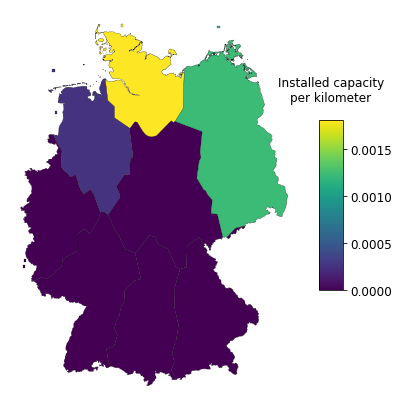

In [39]:
fig, ax = fn.plotLocationalColorMap(esM, 'Wind (onshore)', locFilePath, 'index', perArea=True)

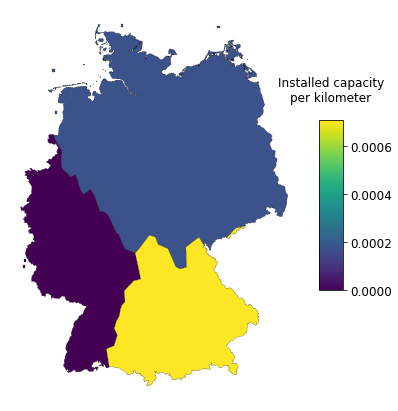

In [40]:
fig, ax = fn.plotLocationalColorMap(esM_aggregated, 'Wind (onshore)', 
                                    aggregated_regions_FilePath, 'index', perArea=True)

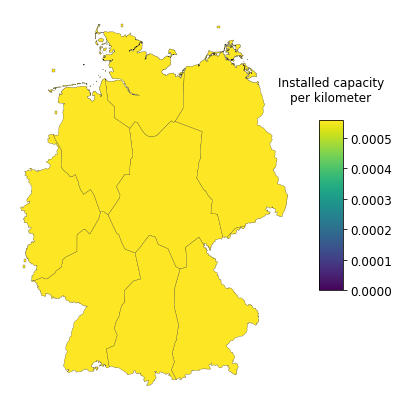

In [41]:
fig, ax = fn.plotLocationalColorMap(esM, 'PV', locFilePath, 'index', perArea=True)

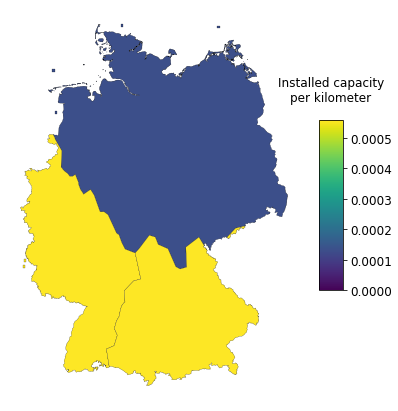

In [42]:
fig, ax = fn.plotLocationalColorMap(esM_aggregated, 'PV', aggregated_regions_FilePath, 'index', perArea=True)

Plot operation time series (either one or two dimensional)

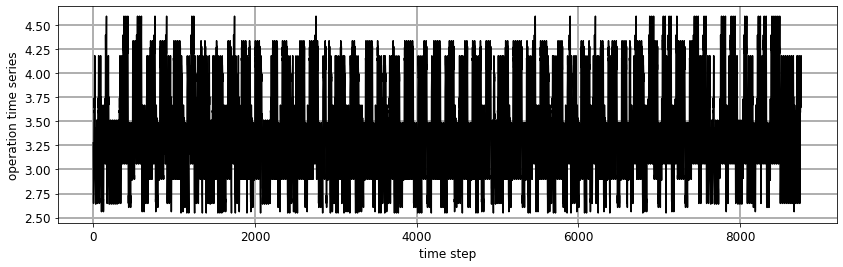

In [43]:
fig, ax = fn.plotOperation(esM, 'Electricity demand', 'cluster_0')

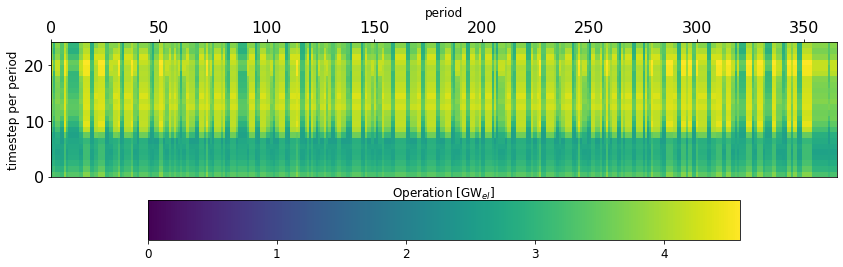

In [44]:
fig, ax = fn.plotOperationColorMap(esM, 'Electricity demand', 'cluster_0')

### Conversion

Show optimization summary

In [45]:
esM.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0   cluster_1  \
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]      2.15756           0   
                           capacity  [GW$_{el}$]       24.7954           0   
                           capexCap  [1e9 Euro/a]      1.84762           0   
                           invest    [1e9 Euro]        12.3977           0   
                           operation [GW$_{el}$*h/a]   83445.1           0   
                           opexCap   [1e9 Euro/a]     0.309942           0   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]            0    0.073463   
                           capacity  [GW$_{el}$]             0    0.898123   
                           capexCap  [1e9 Euro/a]            0   0.0546024   
                           invest    [1e9 Euro]              0    0.628686   
                           operation [GW$_{el}$*h/a]         0     1986.65   
                           opexCap   [1e9 Euro/a]            0   0.0188606   
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]            0  0.00884986   
                           capacity  [GW$_{el}$]             0    0.108194   
                           capexCap  [1e9 Euro/a]            0  0.00657779   
                           invest    [1e9 Euro]              0   0.0757359   
                           operation [GW$_{el}$*h/a]         0     405.783   
                           opexCap   [1e9 Euro/a]            0  0.00227208   

                                                     cluster_2    cluster_3  \
Component                  Property  Unit                                     
Electroylzers              TAC       [1e9 Euro/a]            0  0.000390206   
                           capacity  [GW$_{el}$]             0   0.00448437   
                           capexCap  [1e9 Euro/a]            0  0.000334151   
                           invest    [1e9 Euro]              0   0.00224218   
                           operation [GW$_{el}$*h/a]         0      5.11218   
                           opexCap   [1e9 Euro/a]            0  5.60546e-05   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]     0.452479     0.354389   
                           capacity  [GW$_{el}$]       5.53179      4.33258   
                           capexCap  [1e9 Euro/a]     0.336311     0.263404   
                           invest    [1e9 Euro]        3.87225      3.03281   
                           operation [GW$_{el}$*h/a]   13277.1      10967.6   
                           opexCap   [1e9 Euro/a]     0.116168    0.0909842   
New CCGT plants (hydrogen) TAC       [1e9 Euro/a]     0.485153            0   
                           capacity  [GW$_{el}$]       5.93125            0   
                           capexCap  [1e9 Euro/a]     0.360597            0   
                           invest    [1e9 Euro]        4.15187            0   
                           operation [GW$_{el}$*h/a]   24839.5            0   
                           opexCap   [1e9 Euro/a]     0.124556            0   

                                                      cluster_4  cluster_5  \
Component                  Property  Unit                                    
Electroylzers              TAC       [1e9 Euro/a]      0.672861    1.68521   
                           capacity  [GW$_{el}$]        7.73272     19.367   
                           capexCap  [1e9 Euro/a]      0.576202    1.44313   
                           invest    [1e9 Euro]         3.86636     9.6835   
                           operation [GW$_{el}$*h/a]    18971.2    53161.7   
                           opexCap   [1e9 Euro/a]      0.096659   0.242088   
New CCGT plants (biogas)   TAC       [1e9 Euro/a]        0.3495   0.130244   
                           capacity  [GW$_{el}$]        4.27282     1.5923   
                           capexCap  [1e9 Euro/a]      0.259771  0.0968056   
                           invest    [1e9 Euro]      

In [46]:
esM_aggregated.getOptimizationSummary("ConversionModel", outputLevel=2)

cluster_0_cluster_4_cluster_3_cluster_5  \
Component                Property  Unit                                                      
Electroylzers            TAC       [1e9 Euro/a]                                          0   
                         capacity  [GW$_{el}$]                                           0   
                         capexCap  [1e9 Euro/a]                                          0   
                         invest    [1e9 Euro]                                            0   
                         operation [GW$_{el}$*h/a]                                       0   
                         opexCap   [1e9 Euro/a]                                          0   
New CCGT plants (biogas) TAC       [1e9 Euro/a]                                          0   
                         capacity  [GW$_{el}$]                                           0   
                         capexCap  [1e9 Euro/a]                                          0   
                         invest    [1e9 Euro]                                            0   
                         operation [GW$_{el}$*h/a]                                       0   
                         opexCap   [1e9 Euro/a]                                          0   

                                                   cluster_1_cluster_2  \
Component                Property  Unit                                  
Electroylzers            TAC       [1e9 Euro/a]                1.95007   
                         capacity  [GW$_{el}$]                 11.2054   
                         capexCap  [1e9 Euro/a]                1.66994   
                         invest    [1e9 Euro]                  11.2054   
                         operation [GW$_{el}$*h/a]             34763.3   
                         opexCap   [1e9 Euro/a]               0.280136   
New CCGT plants (biogas) TAC       [1e9 Euro/a]                4.22639   
                         capacity  [GW$_{el}$]                 25.8349   
                         capexCap  [1e9 Euro/a]                3.14133   
                         invest    [1e9 Euro]                  36.1689   
                         operation [GW$_{el}$*h/a]             43993.5   
                         opexCap   [1e9 Euro/a]                1.08507   

                                                   cluster_6_cluster_7  
Component                Property  Unit                                 
Electroylzers            TAC       [1e9 Euro/a]                2.44078  
                         capacity  [GW$_{el}$]                 14.0251  
                         capexCap  [1e9 Euro/a]                2.09015  
                         invest    [1e9 Euro]                  14.0251  
                         operation [GW$_{el}$*h/a]             60560.5  
                         opexCap   [1e9 Euro/a]               0.350627  
New CCGT plants (biogas) TAC       [1e9 Euro/a]               0.194699  
                         capacity  [GW$_{el}$]                 1.19015  
                         capexCap  [1e9 Euro/a]               0.144713  
                         invest    [1e9 Euro]                  1.66621  
                         operation [GW$_{el}$*h/a]             1874.48  
                         opexCap   [1e9 Euro/a]              0.0499862

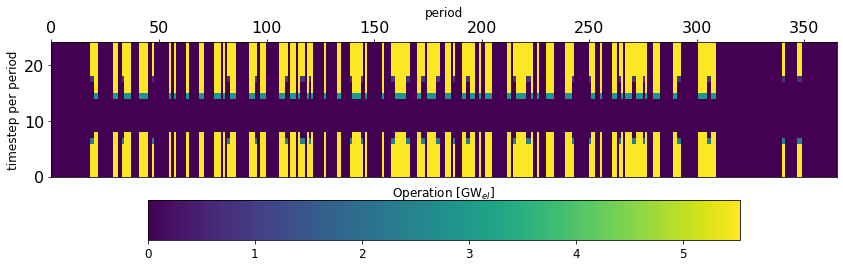

In [47]:
fig, ax = fn.plotOperationColorMap(esM, 'New CCGT plants (biogas)', 'cluster_2')

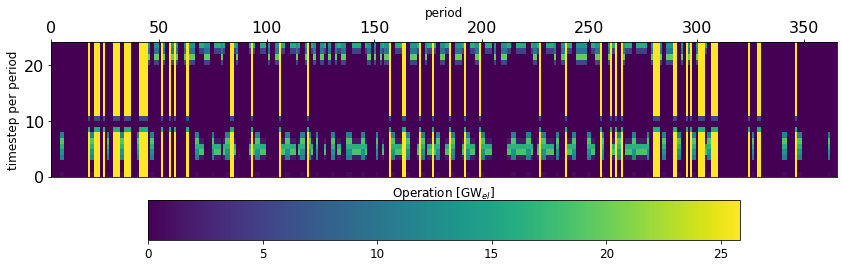

In [48]:
fig, ax = fn.plotOperationColorMap(esM_aggregated, 'New CCGT plants (biogas)', 'cluster_1_cluster_2')

### Storage

Show optimization summary

In [49]:
esM.getOptimizationSummary("StorageModel", outputLevel=2)

cluster_0  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]              0.0442068   
                        capacity           [GW$_{el}$*h]               2.63091   
                        capexCap           [1e9 Euro/a]               0.038945   
                        invest             [1e9 Euro]                 0.397268   
                        operationCharge    [GW$_{el}$*h/a]             973.947   
                        operationDischarge [GW$_{el}$*h/a]             878.383   
                        opexCap            [1e9 Euro/a]             0.00526182   
Pumped hydro storage    TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{el}$*h]                   NaN   
                        operationCharge    [GW$_{el}$*h/a]                 NaN   
                        operationDischarge [GW$_{el}$*h/a]                 NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]             0   
                        capexCap           [1e9 Euro/a]                      0   
                        invest             [1e9 Euro]                        0   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]           0   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]           0   
                        opexCap            [1e9 Euro/a]                      0   
Salt caverns (hydrogen) TAC                [1e9 Euro/a]               0.716143   
                        capacity           [GW$_{H_{2},LHV}$*h]        1235.22   
                        capexCap           [1e9 Euro/a]              0.0120693   
                        invest             [1e9 Euro]                 0.135874   
                        operationCharge    [GW$_{H_{2},LHV}$*h/a]      14226.3   
                        operationDischarge [GW$_{H_{2},LHV}$*h/a]      14226.3   
                        opexCap            [1e9 Euro/a]               0.704073   

                                                                     cluster_1  \
Component               Property           Unit                                  
Li-ion batteries        TAC                [1e9 Euro/a]               0.365173   
                        capacity           [GW$_{el}$*h]               21.7328   
                        capexCap           [1e9 Euro/a]               0.321708   
                        invest             [1e9 Euro]                  3.28166   
                        operationCharge    [GW$_{el}$*h/a]             6844.17   
                        operationDischarge [GW$_{el}$*h/a]             6173.95   
                        opexCap            [1e9 Euro/a]              0.0434656   
Pumped hydro storage    TAC                [1e9 Euro/a]             0.00137868   
                        capacity           [GW$_{el}$*h]                 9.011   
                        operationCharge    [GW$_{el}$*h/a]             3203.36   
                        operationDischarge [GW$_{el}$*h/a]             2480.61   
                        opexCap            [1e9 Euro/a]             0.00137868   
Salt caverns (biogas)   TAC                [1e9 Euro/a]                      0   
                        capacity           [GW$_{biogas,LHV}$*h]           NaN   
                        capexCap           [1e9 Euro/a]                    NaN   
                        invest             [1e9 Euro]                      NaN   
                        operationCharge    [GW$_{biogas,LHV}$*h/a]         NaN   
                        operationDischarge [GW$_{biogas,LHV}$*h/a]         NaN   
                        opexCap            [1e9 Euro/a]                    NaN   
Salt caverns (hydrogen) TAC                [1e9 Eu

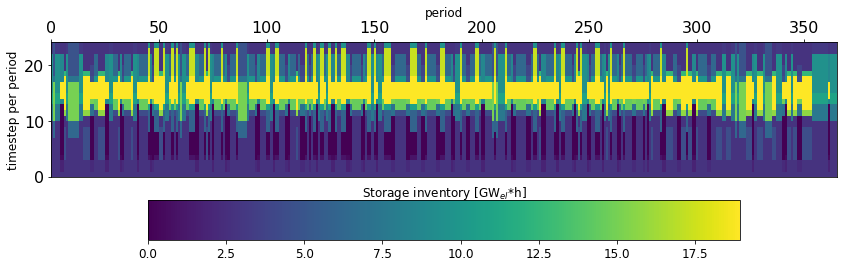

In [50]:
fig, ax = fn.plotOperationColorMap(esM, 'Li-ion batteries', 'cluster_2', 
                                   variableName='stateOfChargeOperationVariablesOptimum')

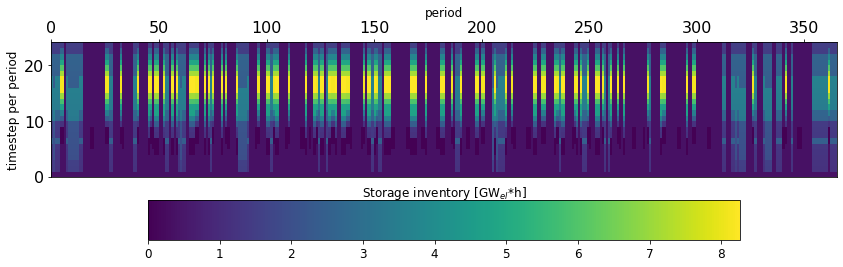

In [51]:
fig, ax = fn.plotOperationColorMap(esM, 'Pumped hydro storage', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

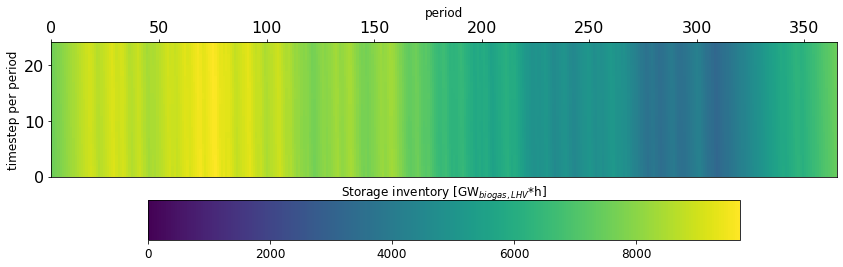

In [52]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (biogas)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

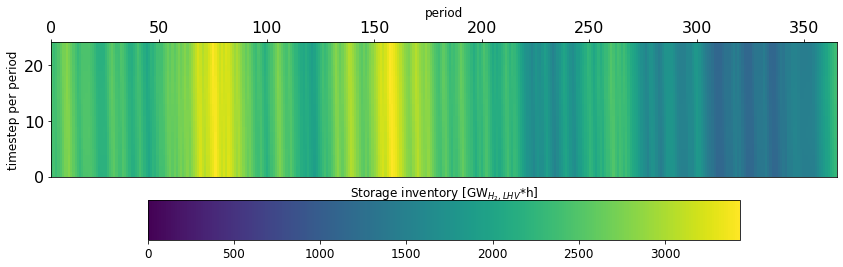

In [53]:
fig, ax = fn.plotOperationColorMap(esM, 'Salt caverns (hydrogen)', 'cluster_2',
                                  variableName='stateOfChargeOperationVariablesOptimum')

## Transmission

Show optimization summary

In [54]:
esM.getOptimizationSummary("TransmissionModel", outputLevel=2).loc['Pipelines (hydrogen)']

cluster_0    cluster_1  \
Property     Unit                   LocationIn                             
TAC          [1e9 Euro/a]           cluster_0             0            0   
                                    cluster_1             0            0   
                                    cluster_2             0  6.45417e-05   
                                    cluster_3             0            0   
                                    cluster_4   0.000117844            0   
                                    cluster_5             0            0   
                                    cluster_6             0            0   
                                    cluster_7             0  3.84993e-05   
capacity     [GW$_{H_{2},LHV}$]     cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN      6.83203   
                                    cluster_3           NaN          NaN   
                                    cluster_4       14.0141          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN      3.32304   
capexCap     [1e9 Euro/a]           cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN  5.07048e-05   
                                    cluster_3           NaN          NaN   
                                    cluster_4   0.000104007          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN  2.46623e-05   
capexIfBuilt [1e9 Euro/a]           cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN  1.38369e-05   
                                    cluster_3           NaN          NaN   
                                    cluster_4   1.38369e-05          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN  1.38369e-05   
invest       [1e9 Euro]             cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN  0.000769635   
                                    cluster_3           NaN          NaN   
                                    cluster_4    0.00140525          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN  0.000459089   
isBuilt      [-]                    cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN            1   
                                    cluster_3           NaN          NaN   
                                    cluster_4             1          NaN   
                                    cluster_5           NaN          NaN   
                                    cluster_6           NaN          NaN   
                                    cluster_7           NaN            1   
operation    [GW$_{H_{2},LHV}$*h/a] cluster_0           NaN          NaN   
                                    cluster_1           NaN          NaN   
                                    cluster_2           NaN      41384.8   
                      

Check that the shared capacity of the pipelines are not exceeded

In [55]:
df=esM.componentModelingDict["TransmissionModel"].capacityVariablesOptimum
df.loc['Pipelines (biogas)']+df.loc['Pipelines (hydrogen)']

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
cluster_0,NaN,NaN,NaN,NaN,14.96504,NaN,NaN,NaN
cluster_1,NaN,NaN,9.565315,NaN,NaN,NaN,NaN,5.197288
cluster_2,NaN,9.565315,NaN,NaN,15.00000,NaN,NaN,NaN
cluster_3,NaN,NaN,NaN,NaN,6.22619,13.523238,NaN,NaN
cluster_4,14.96504,NaN,15.000000,6.226190,NaN,NaN,NaN,NaN
cluster_5,NaN,NaN,NaN,13.523238,NaN,NaN,NaN,NaN
cluster_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.584959
cluster_7,NaN,5.197288,NaN,NaN,NaN,NaN,2.584959,NaN


Plot installed transmission capacities

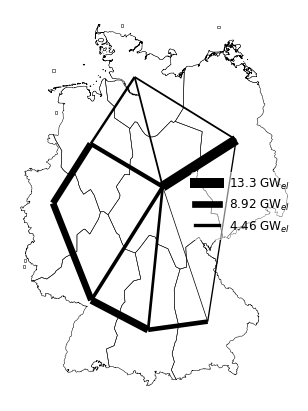

In [56]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'AClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'AC cables', transFilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

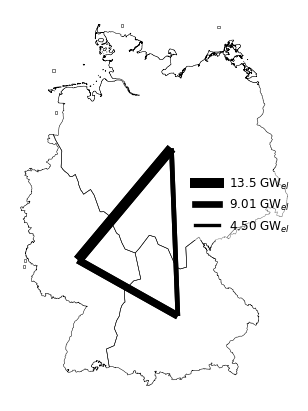

In [57]:
fig, ax = fn.plotLocations(aggregated_regions_FilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM_aggregated, 'AC cables', aggregated_grid_FilePath, loc0='bus0', loc1='bus1', fig=fig, ax=ax)

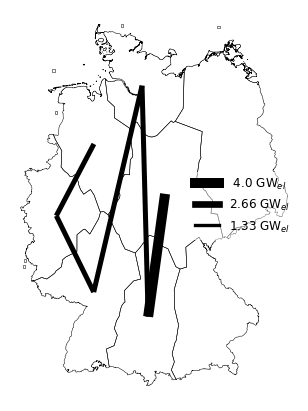

In [58]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'DClines.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'DC cables', transFilePath, loc0='cluster0', loc1='cluster1', fig=fig, ax=ax)

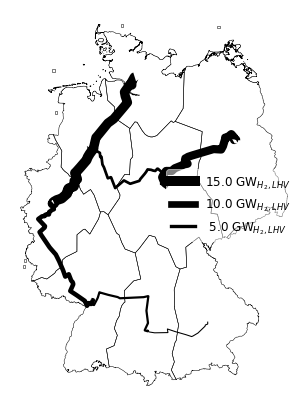

In [59]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (hydrogen)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)

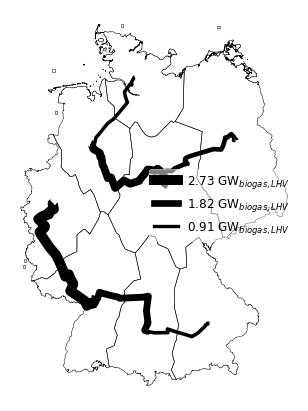

In [60]:
transFilePath = os.path.join(cwd, 'InputData', 'SpatialData','ShapeFiles', 'transmissionPipeline.shp')

fig, ax = fn.plotLocations(locFilePath, indexColumn='index')                                 
fig, ax = fn.plotTransmission(esM, 'Pipelines (biogas)', transFilePath, loc0='cluster0', loc1='cluster1',
                              fig=fig, ax=ax)